In [1]:
import os
import sys
# sys.path.append("/Users/shashanks./Downloads/Installations/ddn/")
sys.path.append("./ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
from bernstein import bernstein_coeff_order10_new
from ddn.pytorch.node import AbstractDeclarativeNode

from utils.viz_helpers import plot_traj
from utils.metrics import get_ade, get_fde

device = 'cpu'

In [72]:
def denoise(gt_x, gt_y, w = 7):
    # denoising
    w = w
    gt_x_t = []
    gt_y_t = []
    for iq in range(len(gt_x)):
        if iq >= w and iq + w <= len(gt_x):
            gt_x_t.append(np.average(gt_x[iq: iq + w]))
            gt_y_t.append(np.average(gt_y[iq: iq + w]))
        elif iq < w:
            okx = np.average(gt_x[w: w + w])
            gt_x_t.append(gt_x[0] + (okx - gt_x[0]) * (iq) / w)
            oky = np.average(gt_y[w: w + w])
            gt_y_t.append(gt_y[0] + (oky - gt_y[0]) * (iq) / w)
        else:
            okx = np.average(gt_x[len(gt_x) - w:len(gt_x) - w  + w])
            oky = np.average(gt_y[len(gt_x) - w: len(gt_x) - w + w])
            gt_x_t.append(okx + (gt_x[-1] - okx) * (w - (len(gt_x) - iq)) / w)
            gt_y_t.append(oky + (gt_y[-1] - oky) * (w - (len(gt_y) - iq)) / w)                   

    gt_x = gt_x_t
    gt_y = gt_y_t
    return gt_x, gt_y

def rotate(gt_x, gt_y,theta):
    gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
    gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
    gt_x = gt_x_x
    gt_y = gt_y_y
    return gt_x, gt_y


class ArgoverseDataset(Dataset):
    def __init__(self, data_path, t_obs=16, dt=0.125,centerline_dir=None, include_centerline = False):
        self.data = np.load(data_path)
        self.data_path = data_path
        self.t_obs = t_obs
        self.dt = dt
        self.include_centerline = include_centerline
        self.centerline_dir = centerline_dir
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        dt = self.dt
        traj = self.data[idx]
        x_traj = traj[:, 0]
        y_traj = traj[:, 1]
        
        x_traj -= x_traj[0]
        y_traj -= y_traj[0]
        
        gt_x = x_traj
        gt_y = y_traj
        
        ind = 1
        
        if idx == ind:
            plt.axis('equal')
#             plt.scatter(gt_x, gt_y, color='blue', label='noisy')
        
        gt_x, gt_y = denoise(gt_x, gt_y)
        v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
        v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]  
        
        if idx == ind:
            plt.axis('equal')
#             plt.scatter(gt_x, gt_y, color='purple',label='before')
        
        # till here, gt-> (50, 1), v -> (49, 1), psi -> (31, 1)
        
        # obtain this -psi
        theta = -psi[self.t_obs - 1]
        
        # rotate by theta
        gt_x, gt_y = rotate(gt_x, gt_y, theta)
#         gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
#         gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
#         gt_x = gt_x_x
#         gt_y = gt_y_y
        if idx == ind:
            plt.axis('equal')
#             plt.scatter(gt_x, gt_y, color='yellow') 
        v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
        v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]
        psidot = [ (psi[k + 1] - psi[k])/dt for k in range(len(psi) - 1) ]
        psi_traj = [i.item() for i in psi]
        psidot_traj = [i.item() for i in psidot]
    
        
        x_traj = gt_x
        y_traj = gt_y

        x_inp = x_traj[:self.t_obs]
        y_inp = y_traj[:self.t_obs]
        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
#         psi_fut = psi_traj[self.t_obs:]
#         psidot_fut = psidot_traj[self.t_obs:]

        # till here, gt-> (32, 1), v -> (31, 1), psi -> (31, 1), psidot -> (30, 1)
        psi_fut = psi_traj[self.t_obs - 1:]
        psidot_fut = psi_traj[self.t_obs - 2:]
        
        vx_traj = v_x
        vy_traj = v_y
        
        vx_beg = vx_traj[self.t_obs]
        vy_beg = vy_traj[self.t_obs]
        
        vx_beg_prev = vx_traj[self.t_obs - 1]
        vy_beg_prev = vy_traj[self.t_obs - 1]
        
        ax_beg = (vx_beg - vx_beg_prev) / self.dt
        ay_beg = (vy_beg - vy_beg_prev) / self.dt

        vx_fin = v_x[-1]
        vy_fin = v_y[-1]
        
        vx_fin_prev = v_x[-2]
        vy_fin_prev = v_y[-2]

        ax_fin = (vx_fin - vx_fin_prev) / self.dt
        ay_fin = (vy_fin - vy_fin_prev) / self.dt

        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
        
#         traj_inp = np.dstack((x_inp, y_inp)).flatten()  
        traj_inp = np.vstack((x_inp, y_inp))
        traj_inp = np.swapaxes(traj_inp, 0, 1)
        
        if self.include_centerline:
            cs = np.load(self.centerline_dir)[idx]
            data = np.load(self.data_path)

            c_x = cs[:, 0]            
            c_y = cs[:, 1]
            c_x -= data[idx][0,0]
            c_y -= data[idx][0,1]
            c_x, c_y = denoise(c_x, c_y)
#             if idx == ind:
#                 plt.plot(c_x, c_y, color='black', label='grey')
            
            # rotate by theta
            c_x, c_y = rotate(c_x, c_y, theta)
            c_x -= c_x[0]
            c_y -= c_y[0]
            c_x += x_inp[-1]
            c_y += y_inp[-1]
        
#             c_y += y_inp[-1] + 2
            c_inp = np.dstack((c_x, c_y)).flatten()
            traj_inp = np.hstack((traj_inp, c_inp))
            
        vx_fut = vx_traj[self.t_obs:]
        vy_fut = vy_traj[self.t_obs:]
#         traj_out = np.vstack((x_fut, y_fut))#.flatten()
#         traj_out = np.swapaxes(traj_out, 0, 1)
        traj_out = np.hstack((x_fut, y_fut)).flatten()      
#         traj_out = np.hstack((x_fut, y_fut)).flatten()

        fixed_params = np.array([x_fut[0], y_fut[0], 0, psi_fut[0], psidot_fut[0]])
        var_inp = np.array([x_inp[-1], y_inp[-1], psi_fut[-1]])

        return torch.tensor(traj_inp), torch.tensor(traj_out), torch.tensor(fixed_params), torch.tensor(var_inp)

In [73]:
class OPTNode(AbstractDeclarativeNode):
    def __init__(self, rho_eq=1.0, rho_goal=1.0, rho_nonhol=1.0, rho_psi=1.0, maxiter=5000, weight_smoothness=1.0, weight_smoothness_psi=1.0, t_fin=2.0, num=30):
        super().__init__()
        self.rho_eq = rho_eq
        self.rho_goal = rho_goal
        self.rho_nonhol = rho_nonhol
        self.rho_psi = rho_psi
        self.maxiter = maxiter
        self.weight_smoothness = weight_smoothness
        self.weight_smoothness_psi = weight_smoothness_psi

        self.t_fin = t_fin
        self.num = num
        self.t = self.t_fin / self.num

        #self.num_batch = 10
        
        tot_time = np.linspace(0.0, self.t_fin, self.num)
        tot_time_copy = tot_time.reshape(self.num, 1)
        self.P, self.Pdot, self.Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
        self.nvar = np.shape(self.P)[1]
        
        self.cost_smoothness = self.weight_smoothness * np.dot(self.Pddot.T, self.Pddot)
        self.cost_smoothness_psi = self.weight_smoothness_psi * np.dot(self.Pddot.T, self.Pddot)
        self.lincost_smoothness_psi = np.zeros(self.nvar)

        self.A_eq = np.vstack((self.P[0], self.P[-1]))
        self.A_eq_psi = np.vstack((self.P[0], self.Pdot[0], self.P[-1]))
        
        self.P = torch.tensor(self.P, dtype=torch.double).to(device)
        self.Pdot = torch.tensor(self.Pdot, dtype=torch.double).to(device)
        self.Pddot = torch.tensor(self.Pddot, dtype=torch.double).to(device)
        self.A_eq = torch.tensor(self.A_eq, dtype=torch.double).to(device)        
        self.A_eq_psi = torch.tensor(self.A_eq_psi, dtype=torch.double).to(device)
        self.cost_smoothness = torch.tensor(self.cost_smoothness, dtype=torch.double).to(device)
        self.cost_smoothness_psi = torch.tensor(self.cost_smoothness_psi, dtype=torch.double).to(device)
        self.lincost_smoothness_psi = torch.tensor(self.lincost_smoothness_psi, dtype=torch.double).to(device)
        
        self.A_nonhol = self.Pdot
        self.A_psi = self.P
        
        self.lamda_x = None
        self.lamda_y = None
        self.lamda_psi = None
        
    def compute_x(self, v, psi, b_eq_x, b_eq_y):
        b_nonhol_x = v * torch.cos(psi)
        b_nonhol_y = v * torch.sin(psi)
    
        cost = self.cost_smoothness + self.rho_nonhol * torch.matmul(self.A_nonhol.T, self.A_nonhol) + self.rho_eq * torch.matmul(self.A_eq.T, self.A_eq)
        lincost_x = -self.lamda_x - self.rho_nonhol * torch.matmul(self.A_nonhol.T, b_nonhol_x.T).T - self.rho_eq * torch.matmul(self.A_eq.T, b_eq_x.T).T
        lincost_y = -self.lamda_y - self.rho_nonhol * torch.matmul(self.A_nonhol.T, b_nonhol_y.T).T - self.rho_eq * torch.matmul(self.A_eq.T, b_eq_y.T).T

        cost_inv = torch.linalg.inv(cost)

        sol_x = torch.matmul(-cost_inv, lincost_x.T).T
        sol_y = torch.matmul(-cost_inv, lincost_y.T).T

        x = torch.matmul(self.P, sol_x.T).T
        xdot = torch.matmul(self.Pdot, sol_x.T).T

        y = torch.matmul(self.P, sol_y.T).T
        ydot = torch.matmul(self.Pdot, sol_y.T).T
         
        return sol_x, sol_y, x, xdot, y, ydot
    
    def compute_psi(self, psi, lamda_psi, psi_temp, b_eq_psi):
        cost = self.cost_smoothness_psi + self.rho_psi * torch.matmul(self.A_psi.T, self.A_psi) + self.rho_eq * torch.matmul(self.A_eq_psi.T, self.A_eq_psi)
        lincost_psi = -self.lamda_psi - self.rho_psi * torch.matmul(self.A_psi.T, psi_temp.T).T - self.rho_eq * torch.matmul(self.A_eq_psi.T, b_eq_psi.T).T

        cost_inv = torch.linalg.inv(cost)

        sol_psi = torch.matmul(-cost_inv, lincost_psi.T).T

        psi = torch.matmul(self.P, sol_psi.T).T

        res_psi = torch.matmul(self.A_psi, sol_psi.T).T - psi_temp
        res_eq_psi = torch.matmul(self.A_eq_psi, sol_psi.T).T - b_eq_psi

        self.lamda_psi = self.lamda_psi - self.rho_psi * torch.matmul(self.A_psi.T, res_psi.T).T - self.rho_eq * torch.matmul(self.A_eq_psi.T, res_eq_psi.T).T

        return sol_psi, np.linalg.norm(res_psi), np.linalg.norm(res_eq_psi), psi

    
    def solve(self, fixed_params, variable_params):
        batch_size, _ = fixed_params.size()
        x_init, y_init, v_init, psi_init, psidot_init = torch.chunk(fixed_params, 5, dim=1)
        x_fin, y_fin, psi_fin = torch.chunk(variable_params, 3, dim=1)
        
        b_eq_x = torch.cat((x_init, x_fin), dim=1)
        b_eq_y = torch.cat((y_init, y_fin), dim=1)
        b_eq_psi = torch.cat((psi_init, psidot_init, psi_fin), dim=1)
        
        v = torch.ones(batch_size, self.num, dtype=torch.double).to(device) * v_init
        psi = torch.ones(batch_size, self.num, dtype=torch.double).to(device) * psi_init
        xdot = v * torch.cos(psi)
        ydot = v * torch.sin(psi)
        
        self.lamda_x = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(device)
        self.lamda_y = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(device)
        self.lamda_psi = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(device)
        
        res_psi_arr = []
        res_eq_psi_arr = []
        res_eq_arr = []
        res_nonhol_arr = []
        for i in range(0, self.maxiter):
            psi_temp = torch.atan2(ydot, xdot)
            c_psi, res_psi, res_eq_psi, psi = self.compute_psi(psi, self.lamda_psi, psi_temp, b_eq_psi)
            c_x, c_y, x, xdot, y, ydot = self.compute_x(v, psi, b_eq_x, b_eq_y)
            
            res_eq_psi_arr.append(res_eq_psi)
            res_psi_arr.append(res_psi)
            v = torch.sqrt(xdot ** 2 + ydot ** 2)
            #v[:, 0] = v_init[:, 0]

            res_eq_x = torch.matmul(self.A_eq, c_x.T).T - b_eq_x
            res_nonhol_x = xdot - v * torch.cos(psi)

            res_eq_y = torch.matmul(self.A_eq, c_y.T).T - b_eq_y
            res_nonhol_y = ydot - v * torch.sin(psi)

            res_eq_arr.append(np.linalg.norm(np.sqrt(res_eq_x**2 + res_eq_y**2)))
            res_nonhol_arr.append(np.linalg.norm(np.sqrt(res_nonhol_x**2 + res_nonhol_y**2)))
            
            self.lamda_x = self.lamda_x - self.rho_eq * torch.matmul(self.A_eq.T, res_eq_x.T).T - self.rho_nonhol * torch.matmul(self.A_nonhol.T, res_nonhol_x.T).T
            self.lamda_y = self.lamda_y - self.rho_eq * torch.matmul(self.A_eq.T, res_eq_y.T).T - self.rho_nonhol * torch.matmul(self.A_nonhol.T, res_nonhol_y.T).T
        
        primal_sol = torch.hstack((c_x, c_y, c_psi, v))
        return primal_sol, None
    
    def objective(self, fixed_params, variable_params, y):
        c_x = y[:, :self.nvar]
        c_y = y[:, self.nvar:2*self.nvar]
        c_psi = y[:, 2*self.nvar:3*self.nvar]
        v = y[:, 3*self.nvar:]
        
        x_init, y_init, v_init, psi_init, psidot_init = torch.chunk(fixed_params, 5, dim=1)
        x_fin, y_fin, psi_fin = torch.chunk(variable_params, 3, dim=1)
        
        x = torch.matmul(self.P, c_x.T).T
        y = torch.matmul(self.P, c_y.T).T
        psi = torch.matmul(self.P, c_psi.T).T
        xdot = torch.matmul(self.Pdot, c_x.T).T
        ydot = torch.matmul(self.Pdot, c_y.T).T
        psidot = torch.matmul(self.Pdot, c_psi.T).T
        xddot = torch.matmul(self.Pddot, c_x.T).T
        yddot = torch.matmul(self.Pddot, c_y.T).T
        psiddot = torch.matmul(self.Pddot, c_psi.T).T
        
        cost_nonhol = 0.5*self.rho_nonhol*torch.sum((xdot - v*torch.cos(psi)) ** 2, 1) + 0.5*self.rho_nonhol*torch.sum((ydot - v*torch.sin(psi)) ** 2, 1)
        cost_pos = 0.5*self.rho_eq*(torch.sum((x[:, -1] - x_fin) ** 2, 1) + torch.sum((y[:, -1] - y_fin) ** 2, 1) + torch.sum((x[:, 0] - x_init) ** 2, 1) + torch.sum((y[:, 0] - y_init) ** 2, 1))
        cost_psi = 0.5*self.rho_eq*(torch.sum((psi[:, -1] - psi_fin) ** 2, 1) + torch.sum((psi[:, 0] - psi_init) ** 2, 1)
                                    + torch.sum((psidot[:, 0] - psidot_init) ** 2, 1))
        #cost_v = 0.5*self.rho_eq*torch.sum((v[:, 0] - v_init) ** 2, 1)
        cost_cancel = torch.diagonal(torch.matmul(-self.lamda_x, c_x.T) + torch.matmul(-self.lamda_y, c_y.T) + torch.matmul(-self.lamda_psi, c_psi.T))
        
        cost_smoothness = 0.5*self.weight_smoothness*(torch.sum(xddot**2, 1) + torch.sum(yddot**2, 1)) + 0.5*self.weight_smoothness_psi*torch.sum(psiddot**2, 1)
        return cost_nonhol + cost_pos + cost_psi + cost_smoothness + cost_cancel #+ cost_v 

In [74]:
class DeclarativeFunction(torch.autograd.Function):
    """Generic declarative autograd function.
    Defines the forward and backward functions. Saves all inputs and outputs,
    which may be memory-inefficient for the specific problem.
    
    Assumptions:
    * All inputs are PyTorch tensors
    * All inputs have a single batch dimension (b, ...)
    """
    @staticmethod
    def forward(ctx, problem, *inputs):
        output, solve_ctx = torch.no_grad()(problem.solve)(*inputs)
        ctx.save_for_backward(output, *inputs)
        ctx.problem = problem
        ctx.solve_ctx = solve_ctx
        return output.clone()

    @staticmethod
    def backward(ctx, grad_output):
        output, *inputs = ctx.saved_tensors
        problem = ctx.problem
        solve_ctx = ctx.solve_ctx
        output.requires_grad = True
        inputs = tuple(inputs)
        grad_inputs = problem.gradient(*inputs, y=output, v=grad_output,
            ctx=solve_ctx)
        return (None, *grad_inputs)

In [75]:
class DeclarativeLayer(torch.nn.Module):
    """Generic declarative layer.
    
    Assumptions:
    * All inputs are PyTorch tensors
    * All inputs have a single batch dimension (b, ...)
    Usage:
        problem = <derived class of *DeclarativeNode>
        declarative_layer = DeclarativeLayer(problem)
        y = declarative_layer(x1, x2, ...)
    """
    def __init__(self, problem):
        super(DeclarativeLayer, self).__init__()
        self.problem = problem
        
    def forward(self, *inputs):
        return DeclarativeFunction.apply(self.problem, *inputs)

In [76]:
class TrajNetLSTMSimple(nn.Module):
    def __init__(self, opt_layer, P, Pdot, input_size=2, hidden_size=16, embedding_size = 128, output_size=2, nvar=11, t_obs=8, num_layers = 1):
        super(TrajNetLSTMSimple, self).__init__()
        self.nvar = nvar
        self.t_obs = t_obs
        self.P = torch.tensor(P, dtype=torch.double).to(device)
        self.Pdot = torch.tensor(Pdot, dtype=torch.double).to(device)        
        self.opt_layer = opt_layer
        self.linear1 = nn.Linear(input_size, embedding_size)
#         self.linear2 = nn.Linear(embedding_size, output_size)
        self.linear2 = nn.Linear(output_size, embedding_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.lstm2 = nn.LSTMCell(embedding_size, hidden_size)        
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.activation = nn.ReLU()
        self.dtype=torch.float64
        self.mask = torch.tensor([[0.0, 0.0, 1.0]], dtype=torch.double).to(device)
        
        
    def forward(self, x, fixed_params, var_inp):
        batch_size, _, _ = x.size()
        out = x
        encoder_hidden = (torch.zeros(batch_size, self.hidden_size, dtype=self.dtype), torch.zeros(batch_size, self.hidden_size, dtype=self.dtype))
#         hidden = self.lstm1(embedded, hidden)
        
        for i in range(20):
            encoder_input = x[:, i, :]
            embedded = self.activation(self.linear1(encoder_input))
            encoder_hidden = self.lstm1(embedded, encoder_hidden)
        
        decoder_input = encoder_input[:, :2]
        decoder_hidden = encoder_hidden
        
        decoder_outputs = torch.zeros(20, 30, 2)
        for i in range(30):
            embedded = self.activation(self.linear2(decoder_input))
            decoder_hidden = self.lstm2(embedded, decoder_hidden)
            decoder_output = self.linear3(decoder_hidden[0])
            decoder_input = decoder_output
            decoder_outputs[:, i, :] = decoder_output
        # Run optimization
        pad_zero = torch.zeros(decoder_output.shape[0], 1)
        variable_params = torch.cat((decoder_output, pad_zero), axis=1)
        # Run optimization
        variable_params = self.mask * var_inp + (1-self.mask) * variable_params

        sol = self.opt_layer(fixed_params, variable_params)
         
        # Compute final trajectory
        x_pred = torch.matmul(self.P, sol[:, :self.nvar].transpose(0, 1))
        y_pred = torch.matmul(self.P, sol[:, self.nvar:2*self.nvar].transpose(0, 1))
        x_pred = x_pred.transpose(0, 1)
        y_pred = y_pred.transpose(0, 1)
#         print(x_pred.shape, y_pred.shape)
        x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[1], 1)
        y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], 1)
#         x_pred = x_pred.reshape(x_pred.size[0], x_pred.size[1], 1).shape
#         y_pred = y_pred.reshape(x_pred.size[0], x_pred.size[1], 1).shape
        out = torch.cat([x_pred, y_pred], dim=2)
#         print(out.shape)
#         print(torch.cat([x_pred, y_pred]).shape)
        return out

class TrajNet(nn.Module):
    def __init__(self, opt_layer, P, Pdot, input_size=2, hidden_size=16, embedding_size = 128, output_size=2, nvar=11, t_obs=8, num_layers = 1):
        super(TrajNet, self).__init__()
        self.nvar = nvar
        self.t_obs = t_obs
        self.P = torch.tensor(P, dtype=torch.double).to(device)
        self.Pdot = torch.tensor(Pdot, dtype=torch.double).to(device)
        self.linear1 = nn.Linear(input_size, embedding_size)
        self.linear2 = nn.Linear(embedding_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size + 1)
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.opt_layer = opt_layer
        self.activation = nn.ReLU()
        self.dtype=torch.float64        
        self.mask = torch.tensor([[0.0, 0.0, 1.0]], dtype=torch.double).to(device)
    
    def forward(self, x, fixed_params, var_inp):
        batch_size, _, __ = x.size()
        x = x.reshape(batch_size, _ * __)
        out1 = self.activation(self.linear1(x)) # 40 to 128
        out2 = self.activation(self.linear2(out1)) # 128 to 16
        variable_params = self.linear3(out2) # 16 to 3
        # to shape (b, 3)

        # Run optimization
        variable_params = self.mask * var_inp + (1-self.mask) * variable_params

        sol = self.opt_layer(fixed_params, variable_params)
         
        # Compute final trajectory
        x_pred = torch.matmul(self.P, sol[:, :self.nvar].transpose(0, 1))
        y_pred = torch.matmul(self.P, sol[:, self.nvar:2*self.nvar].transpose(0, 1))
        x_pred = x_pred.transpose(0, 1)
        y_pred = y_pred.transpose(0, 1)
        out = torch.cat([x_pred, y_pred], dim=1)
        return out
    
class TrajNetLSTM(nn.Module):
    def __init__(self, opt_layer, P, Pdot, input_size=2, hidden_size=16, embedding_size = 2, output_size = 2, nvar=11, t_obs=8, num_layers = 1):
        super(TrajNetLSTM, self).__init__()
        self.nvar = nvar
        self.t_obs = t_obs
        self.P = torch.tensor(P, dtype=torch.double).to(device)
        self.Pdot = torch.tensor(Pdot, dtype=torch.double).to(device)
        self.linear1 = nn.Linear(input_size, embedding_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.linear3 = nn.Linear(embedding_size, 60)
        self.linear3 = nn.Linear(hidden_size, output_size + 1)
        self.encoderlstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.decoderlstm = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True)
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.opt_layer = opt_layer
        self.activation = nn.ReLU()
        self.dtype=torch.float64        
        self.mask = torch.tensor([[0.0, 0.0, 1.0]], dtype=torch.double).to(device)
    
    def forward(self, x, fixed_params, var_inp):
#         batch_size, _ = x.size()
        batch_size, _, __ = x.size()
        out = x
        hidden_state = torch.zeros(self.num_layers, out.size(0), self.hidden_size, dtype=self.dtype)
        cell_state = torch.zeros(self.num_layers, out.size(0), self.hidden_size, dtype=self.dtype)
        torch.nn.init.xavier_normal_(hidden_state)
        torch.nn.init.xavier_normal_(cell_state)
        out, (hidden_state, cell_state) = self.encoderlstm(out, (hidden_state, cell_state))
        
#         # out of shape (b, 20, 2) -> (b, 30, 2)
        pad = torch.zeros(20, 10, self.hidden_size)
        out = torch.cat((out, pad), dim=1)
        
#         # from shape (b, 16) to (b, 2)
        hidden_state = self.linear2(hidden_state)
        cell_state = self.linear2(cell_state)
        out, (hidden_state, cell_state) = self.decoderlstm(out, (hidden_state, cell_state))

#         print(out[:,-1].shape)
        pad_zeros = torch.zeros(out.shape[0], 1, dtype=self.dtype)
        variable_params = torch.cat((out[:, -1],pad_zeros), dim=1)
        
#         variable_params = self.activation(self.linear(out.reshape(out2.shape[0], -1)))

        # Run optimization
        variable_params = self.mask * var_inp + (1-self.mask) * variable_params

        sol = self.opt_layer(fixed_params, variable_params)
         
        # Compute final trajectory
        x_pred = torch.matmul(self.P, sol[:, :self.nvar].transpose(0, 1))
        y_pred = torch.matmul(self.P, sol[:, self.nvar:2*self.nvar].transpose(0, 1))
        x_pred = x_pred.transpose(0, 1)
        y_pred = y_pred.transpose(0, 1)
        out = torch.cat([x_pred, y_pred], dim=1)
        return out

In [84]:
num = 30
t_obs = 20
num_elems = 15
include_centerline = False
name = "final_without" if include_centerline else "final_with"
lr = 0.0001
shuffle = True

train_dataset = ArgoverseDataset("/datasets/argoverse/val_data.npy", centerline_dir="/datasets/argoverse/val_centerlines.npy", t_obs=20, dt=0.3, include_centerline = include_centerline)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=shuffle, num_workers=0)

test_dataset = ArgoverseDataset("/datasets/argoverse/val_test_data.npy", centerline_dir="/datasets/argoverse/val_test_centerlines.npy", t_obs=20, dt=0.3, include_centerline = include_centerline)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=shuffle, num_workers=0)

offsets_train = np.load("/datasets/argoverse/val_offsets.npy")
# offsets_test = np.load("/datasets/argoverse/val_offsets_test.npy")

problem = OPTNode(rho_eq=10, t_fin=9.0, num=num)
opt_layer = DeclarativeLayer(problem)

model = TrajNetLSTM(opt_layer, problem.P, problem.Pdot)#, input_size=t_obs * 2 + include_centerline * num_elems * 2)
# model = TrajNet(opt_layer, problem.P, problem.Pdot)#, input_size=t_obs * 2 + include_centerline * num_elems * 2)
# model = TrajNet(opt_layer, problem.P, problem.Pdot, input_size=t_obs * 2 + include_centerline * num_elems * 2)
model = model.double()
model = model.to(device)

# model.load_state_dict(torch.load("./checkpoints/final.ckpt"))

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.000001)

torch.Size([20, 20, 2]) torch.Size([20, 60])


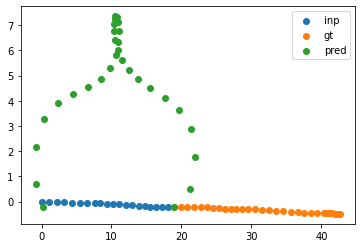

In [85]:
for batch_num, data in enumerate(train_loader):
    traj_inp, traj_out, fixed_params, var_inp = data
    torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)
    print(traj_inp.size(), traj_out.size())
    ade = []
    fde = []
#     out = model(traj_inp.float(), fixed_params.float(), var_inp.float())
    out = model(traj_inp, fixed_params, var_inp)
#     print(out.shape)
#     plt.scatter(traj_inp[1][:40:2], traj_inp[1][1:40:2], label='inp')
    plt.scatter(traj_inp[1,:, 0], traj_inp[1, :, 1], label='inp')
#     plt.scatter(traj_out[1,:, 0], traj_out[1, :, 1], label='gt')
#     plt.scatter(out[1,:, 0].detach(), out[1, :, 1].detach(), label='pred')

    plt.scatter(traj_out[1][:30], traj_out[1][30:], label='gt')
    plt.scatter(out[1][:30].detach(), out[1][30:].detach(), label='pred')
    if include_centerline:
        inp_len=t_obs * 2
        c_len = t_obs * 2 + num_elems * 2
        plt.plot(traj_inp[1][inp_len:c_len:2] , traj_inp[1][inp_len + 1:c_len:2], color='black',label='primary-centerline')
    plt.legend()
    break

Epoch: 0, Batch: 0, Loss: 662.9842206725792
ADE: 29.77078235726639 FDE: 53.929014604663806
Epoch: 0, Batch: 10, Loss: 531.6909953189445
ADE: 25.449284000711366 FDE: 45.18571011282798
Epoch: 0, Batch: 20, Loss: 454.73209674670943
ADE: 23.167437374692632 FDE: 43.509019929504454
Epoch: 0, Batch: 30, Loss: 537.2437292434994
ADE: 26.240295256363673 FDE: 50.287699870517336
Epoch: 0, Batch: 40, Loss: 684.9975481124403
ADE: 29.675048679910372 FDE: 51.43460896545164
Epoch: 0, Mean Loss: 545.8046925807823
Mean ADE: 25.703363095156927 Mean FDE: 47.6696212722491
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Loss: 606.8218123004161
ADE: 28.557348992100618 FDE: 53.916469906367524


KeyboardInterrupt: 

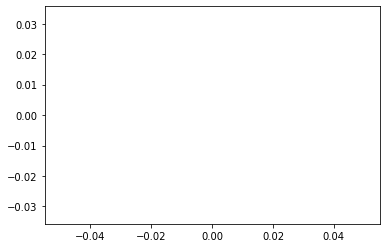

In [86]:
epoch_train_loss = []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = []
    mean_ade = []
    mean_fde = []    
    for batch_num, data in enumerate(train_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)

        ade = []
        fde = []            
#         out = model(traj_inp.float(), fixed_params.float(), var_inp.float())
        out = model(traj_inp, fixed_params, var_inp)
        loss = criterion(out, traj_out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j].item(),out[ii][j + num].item()] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j].item(),traj_out[ii][j + num].item()] for j in range(len(out[ii])//2)]
#             ade.append(get_ade(np.array(out[ii].detach()), np.array(traj_out[ii].detach())))
#             fde.append(get_fde(np.array(out[ii].detach()), np.array(traj_out[ii].detach())))
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))                                    
#             plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=include_centerline, inp_len=t_obs * 2, c_len = t_obs * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)
        if batch_num % 10 == 0:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch, batch_num, loss.item()))
            print("ADE: {}".format(np.mean(ade)), "FDE: {}".format(np.mean(fde)))

        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))

    mean_loss = np.mean(train_loss)
    epoch_train_loss.append(mean_loss)
    torch.save(model.state_dict(), "./checkpoints/{}.ckpt".format(name))
    print("Epoch: {}, Mean Loss: {}".format(epoch, mean_loss))
    print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))
    print("-"*100)

Batch: 0, Loss: 14.400999027443135
Batch: 1, Loss: 11.699043619684053
Batch: 2, Loss: 8.618406937053239
Batch: 3, Loss: 5.229336737043434
Batch: 4, Loss: 6.6153500760466
Batch: 5, Loss: 7.819490196908543
Batch: 6, Loss: 18.122736699381505
Batch: 7, Loss: 13.311774520411692
Batch: 8, Loss: 21.00286850690768
Batch: 9, Loss: 14.720169439894413
Epoch Mean Test Loss: 12.15401757607743
Mean ADE: 3.391014935577728 Mean FDE: 5.738302015315152


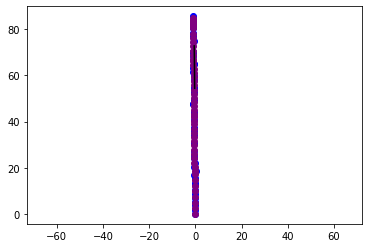

In [148]:
with torch.no_grad():
    cnt = 0
    test_loss = []
    mean_ade = []
    mean_fde = []     
    for batch_num, data in enumerate(test_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)
        
        ade = []
        fde = []        
        
        out = model(traj_inp, fixed_params, var_inp)
        loss = criterion(out, traj_out)
        
        test_loss.append(loss.item())
        print("Batch: {}, Loss: {}".format(batch_num, loss.item()))
        
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))                        
            plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=include_centerline, inp_len=num * 2, c_len = num * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)

        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))  

mean_loss = np.mean(test_loss)
print("Epoch Mean Test Loss: {}".format(mean_loss))
print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))

In [8]:
def denoise(gt_x, gt_y, w = 7):
    # denoising
    w = w
    gt_x_t = []
    gt_y_t = []
    for iq in range(len(gt_x)):
        if iq >= w and iq + w <= len(gt_x):
            gt_x_t.append(np.average(gt_x[iq: iq + w]))
            gt_y_t.append(np.average(gt_y[iq: iq + w]))
        elif iq < w:
            okx = np.average(gt_x[w: w + w])
            gt_x_t.append(gt_x[0] + (okx - gt_x[0]) * (iq) / w)
            oky = np.average(gt_y[w: w + w])
            gt_y_t.append(gt_y[0] + (oky - gt_y[0]) * (iq) / w)
        else:
            okx = np.average(gt_x[len(gt_x) - w:len(gt_x) - w  + w])
            oky = np.average(gt_y[len(gt_x) - w: len(gt_x) - w + w])
            gt_x_t.append(okx + (gt_x[-1] - okx) * (w - (len(gt_x) - iq)) / w)
            gt_y_t.append(oky + (gt_y[-1] - oky) * (w - (len(gt_y) - iq)) / w)                   

    gt_x = gt_x_t
    gt_y = gt_y_t
    return gt_x, gt_y

def rotate(gt_x, gt_y,theta):
    gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
    gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
    gt_x = gt_x_x
    gt_y = gt_y_y
    return gt_x, gt_y


class ArgoverseDataset(Dataset):
    def __init__(self, data_path, t_obs=16, dt=0.125,centerline_dir=None, include_centerline = False):
        self.data = np.load(data_path)
        self.data_path = data_path
        self.t_obs = t_obs
        self.dt = dt
        self.include_centerline = include_centerline
        self.centerline_dir = centerline_dir
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        dt = self.dt
        traj = self.data[idx]
        x_traj = traj[:, 0]
        y_traj = traj[:, 1]
        
        x_traj -= x_traj[0]
        y_traj -= y_traj[0]
        
        gt_x = x_traj
        gt_y = y_traj
        
        ind = 1
        
        if idx == ind:
            plt.axis('equal')
#             plt.scatter(gt_x, gt_y, color='blue', label='noisy')
        
        gt_x, gt_y = denoise(gt_x, gt_y)
        v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
        v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]  
        
        if idx == ind:
            plt.axis('equal')
#             plt.scatter(gt_x, gt_y, color='purple',label='before')
        
        # till here, gt-> (50, 1), v -> (49, 1), psi -> (31, 1)
        
        # obtain this -psi
        theta = -psi[self.t_obs - 1]
        
        # rotate by theta
        gt_x, gt_y = rotate(gt_x, gt_y, theta)
#         gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
#         gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
#         gt_x = gt_x_x
#         gt_y = gt_y_y
        if idx == ind:
            plt.axis('equal')
#             plt.scatter(gt_x, gt_y, color='yellow') 
        v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
        v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]
        psidot = [ (psi[k + 1] - psi[k])/dt for k in range(len(psi) - 1) ]
        psi_traj = [i.item() for i in psi]
        psidot_traj = [i.item() for i in psidot]
    
        
        x_traj = gt_x
        y_traj = gt_y

        x_inp = x_traj[:self.t_obs]
        y_inp = y_traj[:self.t_obs]
        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
#         psi_fut = psi_traj[self.t_obs:]
#         psidot_fut = psidot_traj[self.t_obs:]

        # till here, gt-> (32, 1), v -> (31, 1), psi -> (31, 1), psidot -> (30, 1)
        psi_fut = psi_traj[self.t_obs - 1:]
        psidot_fut = psi_traj[self.t_obs - 2:]
        
        vx_traj = v_x
        vy_traj = v_y
        
        vx_beg = vx_traj[self.t_obs]
        vy_beg = vy_traj[self.t_obs]
        
        vx_beg_prev = vx_traj[self.t_obs - 1]
        vy_beg_prev = vy_traj[self.t_obs - 1]
        
        ax_beg = (vx_beg - vx_beg_prev) / self.dt
        ay_beg = (vy_beg - vy_beg_prev) / self.dt

        vx_fin = v_x[-1]
        vy_fin = v_y[-1]
        
        vx_fin_prev = v_x[-2]
        vy_fin_prev = v_y[-2]

        ax_fin = (vx_fin - vx_fin_prev) / self.dt
        ay_fin = (vy_fin - vy_fin_prev) / self.dt

        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
        
        traj_inp = np.dstack((x_inp, y_inp)).flatten()        
        if self.include_centerline:
            cs = np.load(self.centerline_dir)[idx]
            data = np.load(self.data_path)

            c_x = cs[:, 0]            
            c_y = cs[:, 1]
            c_x -= data[idx][0,0]
            c_y -= data[idx][0,1]
            c_x, c_y = denoise(c_x, c_y)
#             if idx == ind:
#                 plt.plot(c_x, c_y, color='black', label='grey')
            
            # rotate by theta
            c_x, c_y = rotate(c_x, c_y, theta)
            c_x -= c_x[0]
            c_y -= c_y[0]
            c_x += x_inp[-1]
            c_y += y_inp[-1]
        
#             c_y += y_inp[-1] + 2
            c_inp = np.dstack((c_x, c_y)).flatten()
            traj_inp = np.hstack((traj_inp, c_inp))
            
        vx_fut = vx_traj[self.t_obs:]
        vy_fut = vy_traj[self.t_obs:]
        traj_out = np.hstack((x_fut, y_fut)).flatten()

        fixed_params = np.array([x_fut[0], y_fut[0], 0, psi_fut[0], psidot_fut[0]])
        var_inp = np.array([x_inp[-1], y_inp[-1], psi_fut[-1]])

#             print(fixed_params)
#             print(var_inp)
        return torch.tensor(traj_inp), torch.tensor(traj_out), torch.tensor(fixed_params), torch.tensor(var_inp)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def plot_traj(cnt, traj_inp, traj_out, traj_pred, obs, batch_num=0, num = 30, offsets = [], cities = [], avm = None, center = True, mode = "train", inp_len=40, c_len=70):
    traj_inp = traj_inp.numpy()
    traj_out = traj_out.numpy()
    traj_pred = traj_pred.detach().numpy()
    
    lane_centerlines = []
    ind = batch_num * 20 + cnt

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # Get lane centerlines which lie within the range of trajectories
    ox = offsets[ind][0] + 2
    oy = offsets[ind][1] + 2
    ox = 0
    oy = 0
    if avm is not None:
        city = cities[ind]
        ox = offsets[ind][0] + 2
        oy = offsets[ind][1] + 2
        x_max = np.max(np.concatenate((traj_inp[:inp_len:2], traj_out[:num], traj_pred[:num]), axis=0)) + ox
        x_min = np.min(np.concatenate((traj_inp[:inp_len:2], traj_out[:num], traj_pred[:num]), axis=0)) + ox
        y_max = np.max(np.concatenate((traj_inp[1:inp_len:2], traj_out[num:], traj_pred[num:]), axis=0)) + oy
        y_min = np.min(np.concatenate((traj_inp[1:inp_len:2], traj_out[num:], traj_pred[num:]), axis=0)) + oy
        
        seq_lane_props = avm.city_lane_centerlines_dict[city]
        for lane_id, lane_props in seq_lane_props.items():
            lane_cl = lane_props.centerline

            if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
                lane_centerlines.append(lane_cl)

        for lane_cl in lane_centerlines:
            if True:
                ax.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)

    ax.scatter(traj_inp[:inp_len:2] + ox, traj_inp[1:inp_len:2] + oy, color='blue', label='Inp traj')
    ax.scatter(traj_out[:num] + ox, traj_out[num:] + oy, color='orange', label='GT')
    ax.scatter(traj_pred[:num] + ox, traj_pred[num:] + oy, color='green', label='Pred')

    if center:
        ax.plot(traj_inp[inp_len:c_len:2] + ox , traj_inp[inp_len + 1:c_len:2] + oy, color='black',label='primary-centerline')
    
    ax.legend()
    ax.axis('equal')
    if mode == "train":
        plt.savefig('./results/{}.png'.format(cnt))
    else:
        plt.savefig('./results/{}.png'.format(batch_num * 20 + cnt))
    plt.close()
